In [1]:
# !pip install transformers accelerate evaluate datasets peft -q

In [2]:
import transformers
import accelerate
import peft

print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")
print(f"PEFT version: {peft.__version__}")

Transformers version: 4.34.0
Accelerate version: 0.23.0
PEFT version: 0.5.0


In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
model_checkpoint = "google/vit-base-patch16-224-in21k"

In [5]:
from datasets import load_dataset

dataset = load_dataset("food101", split="train[:5000]")

6
beignets


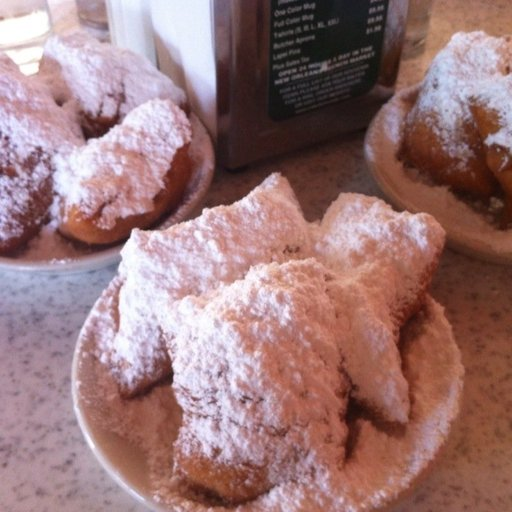

In [6]:
print(dataset['label'][1])
print(dataset.features["label"].names[:][6])
dataset['image'][1]

In [7]:
labels = dataset.features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'baklava'

In [8]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)

In [9]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
train_transforms = Compose(
    [
        RandomResizedCrop(image_processor.size["height"]),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)

val_transforms = Compose(
    [
        Resize(image_processor.size["height"]),
        CenterCrop(image_processor.size["height"]),
        ToTensor(),
        normalize,
    ]
)


def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [train_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch


def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [10]:
splits = dataset.train_test_split(test_size=0.1)
train_ds = splits["train"]
val_ds = splits["test"]

In [11]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [12]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [13]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
print_trainable_parameters(model)

trainable params: 85876325 || all params: 85876325 || trainable%: 100.00


In [15]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

trainable params: 745162 || all params: 86543818 || trainable%: 0.86


In [16]:
from transformers import TrainingArguments, Trainer


model_name = model_checkpoint.split("/")[-1]
batch_size = 32

args = TrainingArguments(
    f"{model_name}-finetuned-lora-food101",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-3,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    label_names=["labels"],
)

In [17]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [18]:
import torch


def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [19]:
trainer = Trainer(
    lora_model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)
train_results = trainer.train()

  0%|          | 0/175 [00:00<?, ?it/s]

{'loss': 2.1965, 'learning_rate': 0.004714285714285714, 'epoch': 0.28}
{'loss': 0.3704, 'learning_rate': 0.004428571428571428, 'epoch': 0.57}
{'loss': 0.236, 'learning_rate': 0.0041428571428571434, 'epoch': 0.85}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.1573263555765152, 'eval_accuracy': 0.95, 'eval_runtime': 10.3363, 'eval_samples_per_second': 48.373, 'eval_steps_per_second': 1.548, 'epoch': 0.99}
{'loss': 0.274, 'learning_rate': 0.0038571428571428576, 'epoch': 1.13}
{'loss': 0.2009, 'learning_rate': 0.0035714285714285718, 'epoch': 1.42}
{'loss': 0.2027, 'learning_rate': 0.003285714285714286, 'epoch': 1.7}
{'loss': 0.1977, 'learning_rate': 0.003, 'epoch': 1.99}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.17175757884979248, 'eval_accuracy': 0.942, 'eval_runtime': 10.3268, 'eval_samples_per_second': 48.418, 'eval_steps_per_second': 1.549, 'epoch': 1.99}
{'loss': 0.1732, 'learning_rate': 0.0027142857142857142, 'epoch': 2.27}
{'loss': 0.2255, 'learning_rate': 0.002428571428571429, 'epoch': 2.55}
{'loss': 0.153, 'learning_rate': 0.002142857142857143, 'epoch': 2.84}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.1482047587633133, 'eval_accuracy': 0.944, 'eval_runtime': 10.1302, 'eval_samples_per_second': 49.358, 'eval_steps_per_second': 1.579, 'epoch': 2.98}
{'loss': 0.1475, 'learning_rate': 0.0018571428571428573, 'epoch': 3.12}
{'loss': 0.1075, 'learning_rate': 0.0015714285714285715, 'epoch': 3.4}
{'loss': 0.1354, 'learning_rate': 0.0012857142857142856, 'epoch': 3.69}
{'loss': 0.1186, 'learning_rate': 0.001, 'epoch': 3.97}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.13983087241649628, 'eval_accuracy': 0.96, 'eval_runtime': 10.134, 'eval_samples_per_second': 49.339, 'eval_steps_per_second': 1.579, 'epoch': 4.0}
{'loss': 0.0989, 'learning_rate': 0.0007142857142857143, 'epoch': 4.26}
{'loss': 0.1107, 'learning_rate': 0.0004285714285714286, 'epoch': 4.54}
{'loss': 0.1002, 'learning_rate': 0.00014285714285714287, 'epoch': 4.82}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.13497132062911987, 'eval_accuracy': 0.958, 'eval_runtime': 10.1336, 'eval_samples_per_second': 49.341, 'eval_steps_per_second': 1.579, 'epoch': 4.96}
{'train_runtime': 951.5874, 'train_samples_per_second': 23.645, 'train_steps_per_second': 0.184, 'train_loss': 0.2913237018244607, 'epoch': 4.96}


In [20]:
trainer.evaluate(val_ds)

  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.13983087241649628,
 'eval_accuracy': 0.96,
 'eval_runtime': 10.1697,
 'eval_samples_per_second': 49.166,
 'eval_steps_per_second': 1.573,
 'epoch': 4.96}

In [22]:
repo_name = f"Paresh/{model_name}-finetuned-lora-food101"
lora_model.push_to_hub(repo_name)

CommitInfo(commit_url='https://huggingface.co/Paresh/vit-base-patch16-224-in21k-finetuned-lora-food101/commit/105af4ec9ebdc41bdb5c86f99ab715badfd32497', commit_message='Upload model', commit_description='', oid='105af4ec9ebdc41bdb5c86f99ab715badfd32497', pr_url=None, pr_revision=None, pr_num=None)

In [23]:
from peft import PeftConfig, PeftModel


config = PeftConfig.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(
    config.base_model_name_or_path,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)
# Load the LoRA model
inference_model = PeftModel.from_pretrained(model, repo_name)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


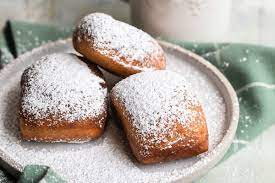

In [26]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/beignets.jpeg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [27]:
image_processor = AutoImageProcessor.from_pretrained(repo_name)

In [28]:
encoding = image_processor(image.convert("RGB"), return_tensors="pt")

In [31]:
with torch.no_grad():
    outputs = inference_model(**encoding)
    logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", inference_model.config.id2label[predicted_class_idx])

Predicted class: beignets
